In [1]:
from PIL import Image
import tqdm
import os
import time
import collections

import torch
import torchvision
assert torch.cuda.is_available()
from torchvision.transforms import ToTensor
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

AMOUNT = None
BATCH_SIZE = 60
VAL_SIZE = 0.2
IM_SIZE = (128, 128)
DEVICE = 'cuda:0'

----------------
## Создание Custom Dataset  и DataLoader
Объект класса ImageDataset подгружает файл с нужным изображением при вызове метода \__getitem__.

Работа происходит в цветовом пространстве HSV:
- hue - оттенок (image[0]),
- saturation - насыщенность (image[1]),
- value - значение яркости (image[2])

Яркость будет неизменным и опорным значением для модели, по которому будут рассчитываться два оставшихся параметра, влияющих на цвет.


In [2]:
def dataset_preparation(in_path, out_path, im_size):
    ''' перезаписывает файлы в другую папку + resize '''
    files_list = os.listdir(in_path)
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    for file_n in tqdm.tqdm(files_list):
        with Image.open(in_path+file_n) as file:
            file.resize(im_size).save(out_path+file_n)

class ImageDataset(torch.utils.data.Dataset):
    ''' 
    Формат файлов: png или jpg
    amount - временное решение по ограничению кол-ва обучающих данных
    '''
    
    def __init__(self, path, transforms, amount = None, to_hsv = True):
        self.transforms = transforms
        self.to_hsv = to_hsv
        self.path = path
        
        is_image_filter = lambda value:('png' in value) or ('jpg' in value) or ('JPEG' in value)
        self.f_names = list(filter(is_image_filter, os.listdir(path)))[:amount]
        self.len = len(self.f_names)
        
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        with Image.open(self.path + self.f_names[index]) as file:
            image = self.transforms(file.convert('HSV')) 
            return image[2].unsqueeze(0), image[:2]     # unsqueeze на случай реализации vgg16
                                                        # image shape - [hue, sat, val], return [newax, h, s]

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
# dataset_preparation(in_path = 'imagenet_val_mini/',
#                     out_path = 'im_dataset/',
#                     im_size = IM_SIZE)
dataset = ImageDataset(path = 'im_dataset/', transforms = transforms, amount = AMOUNT)

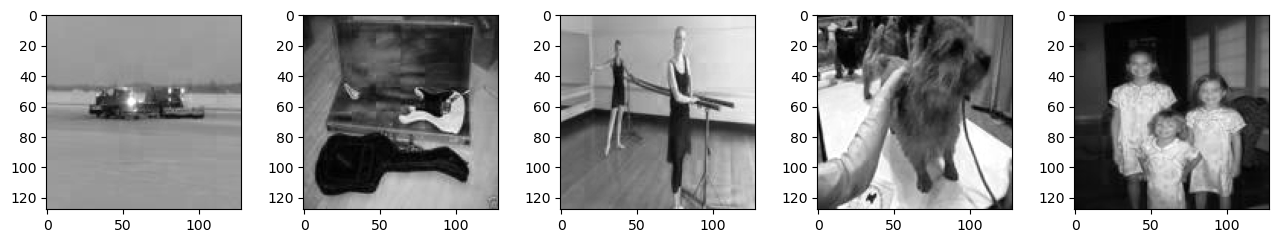

In [3]:
%matplotlib inline
_, ax = plt.subplots(1, 5, figsize = (13, 5))
plt.tight_layout()
for i in range(5):
    ax[i].imshow(dataset[i][0].permute(1, 2, 0), cmap = 'gray')

In [4]:
def val_split(dataset, val_size):
    ''' val_size задается в диапазоне 0..1 '''
    val_length = int(np.round(len(dataset) * val_size))
    val_idx = range(val_length)
    train_idx = range(val_length, len(dataset))
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    return train_sampler, val_sampler

train_sampler, val_sampler = val_split(dataset, val_size = VAL_SIZE)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler, drop_last = True)
val_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = val_sampler, drop_last = True)

---------------------------------------
## Архитектура модели
StylerNet - U-Net подобная архитектура

https://medium.com/@sanjay035/sketch-to-color-anime-translation-using-generative-adversarial-networks-gans-8f4f69594aeb


In [12]:
class StylerNet(torch.nn.Module):
    ''' 
    StylerNet - U-net подобная архитектура
    идея: https://medium.com/@sanjay035/sketch-to-color-anime-translation-using-generative-adversarial-networks-gans-8f4f69594aeb
    '''
    
    def __init__(self, optim):
        super(StylerNet, self).__init__()

        self.l1_encoder = torch.nn.Sequential(
            
            collections.OrderedDict({
                'conv1': torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1, stride = 2),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(64)
                ),
                'conv2': torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1, stride = 2),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(128)
                ),
                'conv3': torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1, stride = 2),
                    torch.nn.LeakyReLU(), 
                    torch.nn.BatchNorm2d(256),
                ),
                'conv4': torch.nn.Sequential(            
                    torch.nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1, stride = 2),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(512)
                )
            })
        )
        self.l2_decoder = torch.nn.Sequential(
            
            collections.OrderedDict({
                'convTranspose1': torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(256)
                ),
                'convTranspose2': torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(128),
                ),
                'convTranspose3': torch.nn.Sequential(            
                    torch.nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(64),
                ),
                'convTranspose4': torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(32),
                ),
                'convOut': torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels = 32, out_channels = 2, kernel_size = 3, padding = 1),
                    torch.nn.BatchNorm2d(2),
                    torch.nn.Sigmoid()
                )
            })    
        )
        self.loss_fn = torch.nn.BCELoss()
        self.optim = optim(self.parameters(), lr = .001, weight_decay=0.1)
        
    def forward(self, x):
#         print('x input: ', x.shape)
#         with torch.no_grad():
        x1 = self.l1_encoder.conv1(x)          # (, 64, 64, 64)
        x2 = self.l1_encoder.conv2(x1)         # (, 128, 32, 32)
        x3 = self.l1_encoder.conv3(x2)         # (, 256, 16, 16)
        x4 = self.l1_encoder.conv4(x3)         # (, 512, 8, 8)
        
        x = self.l2_decoder.convTranspose1(x4)
        
        x = torch.cat((x, x3), dim = 1)        # ( , 512, 16, 16)
        x = self.l2_decoder.convTranspose2(x)  
        x = torch.cat((x, x2), dim = 1)        # ( , 256, 32, 32)
        x = self.l2_decoder.convTranspose3(x)
        x = torch.cat((x, x1), dim = 1)        # ( , 128, 64, 64)
        x = self.l2_decoder.convTranspose4(x)  # ( , 32, 128, 128)
        
        x = self.l2_decoder.convOut(x)
#         print('decoder out: ', x.shape)
        return x
    
    def calc_loss(self, outputs, targets):
        return self.loss_fn(outputs, targets)
            
    def predict(self, inputs):
        topillow = torchvision.transforms.ToPILImage('HSV')
        image = topillow(torch.hstack([self(inputs.to(DEVICE)), inputs.to(DEVICE)])[0])
        return image
    def checkpoint(self, direction, epoch):
        torch.save(self.state_dict, direction + f'model_{epoch}')
    def load_checkpoint(self, direction, epoch):
        self.load_state_dict(torch.load(direction + f'model_{epoch}')())

--------------
## Обучение

In [6]:
def train_model3(model, train_loader, epochs = 1, device = DEVICE):
    model.to(device)
    model.train()
    
    # для val_loss
    calc_loss = torch.nn.MSELoss()
    topillow = torchvision.transforms.ToPILImage('HSV')
    image = next(iter(train_loader))     # image shape   [[s, h], v]
    
    point = np.ceil(len(train_loader) / 10)
    losses = [np.array([]), np.array([])]
    
    for epoch in range(epochs):
        model.to(device)
        start_time = time.time()
        print(f'Epoch {epoch}/{epochs}: <', end = '')
        
        for i, (inputs, targets) in enumerate(train_loader):
            model.optim.zero_grad()
            model_outs = model(inputs.to(device))
            model_loss = model.calc_loss(model_outs, targets.to(device))
            model_loss.backward()
            model.optim.step()
            
            
            if not i % point:
                print('=', end = '')
                
        print(f'> ------- model loss = {model_loss}, time = {np.round(time.time() - start_time)}s')
        
        losses[1] = np.append(losses[1], model_loss.detach().to('cpu').numpy())
        
        
        if not epoch % 5:
            model.checkpoint('checkpoints/', epoch)
            
            # расчет validation loss    
            with torch.no_grad():                  
                val_loss = 0
                for i, (inputs, targets) in enumerate(val_loader):
                    outputs = model(inputs.to(device))
                    val_loss += calc_loss(outputs, targets.to(device))
#                 val_loss = val_loss / i
                print(f'\nValidation loss = {val_loss}')
                
                # визуальный вывод
                fake_im = model.predict(image[0])
                real_im = topillow(torch.hstack((image[1], image[0]))[0])
                _, ax = plt.subplots(1, 3, figsize = (10, 2))
                plt.tight_layout()
                ax[0].set_title('fake image')
                ax[0].imshow(fake_im)
                ax[1].set_title('real image')
                ax[1].imshow(real_im)
                ax[2].set_title('losses')
                ax[2].plot(losses[1], label = 'model loss')
                ax[2].legend()
                plt.show()
                
    return losses

In [13]:
model = StylerNet(optim = torch.optim.Adam)
model_params_amount = (sum(p.numel() for p in model.parameters()))
print(f'Количество параметров модели: {model_params_amount}')

Количество параметров модели: 10163430


Epoch 0/1000: <==========> ------- model loss = 0.7129561305046082, time = 21.0s

Validation loss = 1.9264496564865112


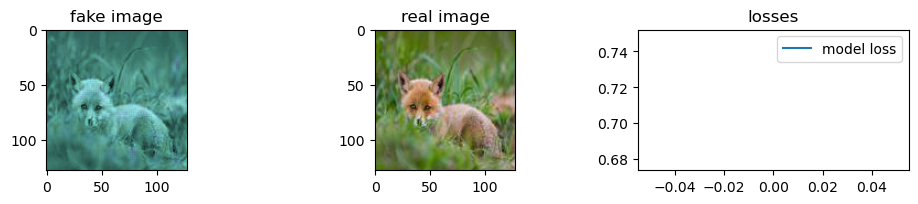

Epoch 1/1000: <==========> ------- model loss = 0.7079880237579346, time = 21.0s
Epoch 2/1000: <==========> ------- model loss = 0.6886324882507324, time = 21.0s
Epoch 3/1000: <==========> ------- model loss = 0.6669608354568481, time = 21.0s
Epoch 4/1000: <==========> ------- model loss = 0.6682785153388977, time = 21.0s
Epoch 5/1000: <==========> ------- model loss = 0.6648784279823303, time = 21.0s

Validation loss = 1.6090998649597168


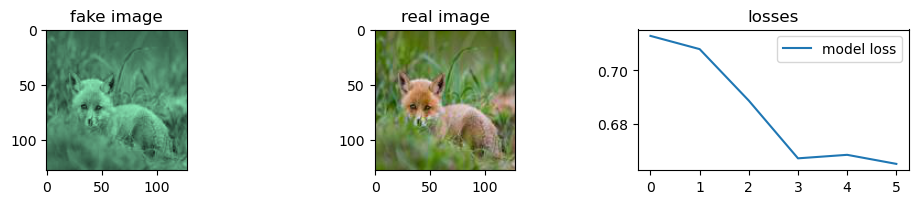

Epoch 6/1000: <==========> ------- model loss = 0.6622121334075928, time = 21.0s
Epoch 7/1000: <==========> ------- model loss = 0.6453635096549988, time = 21.0s
Epoch 8/1000: <==========> ------- model loss = 0.628696084022522, time = 21.0s
Epoch 9/1000: <==========> ------- model loss = 0.6311452984809875, time = 21.0s
Epoch 10/1000: <==========> ------- model loss = 0.6258924007415771, time = 21.0s

Validation loss = 1.4814105033874512


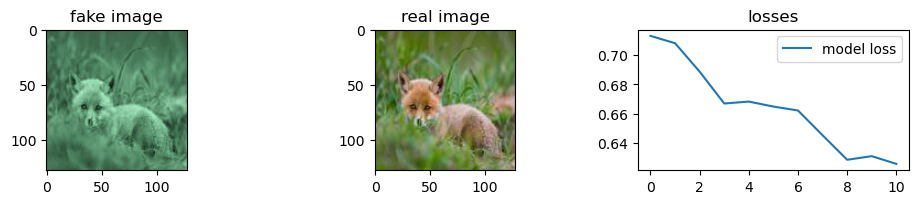

Epoch 11/1000: <==========> ------- model loss = 0.6409242749214172, time = 21.0s
Epoch 12/1000: <==========> ------- model loss = 0.6309716105461121, time = 21.0s
Epoch 13/1000: <==========> ------- model loss = 0.6371734142303467, time = 21.0s
Epoch 14/1000: <==========> ------- model loss = 0.6209849119186401, time = 21.0s
Epoch 15/1000: <==========> ------- model loss = 0.625158965587616, time = 21.0s

Validation loss = 1.4677696228027344


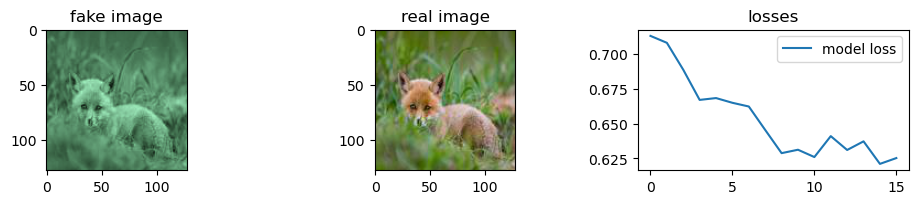

Epoch 16/1000: <==========> ------- model loss = 0.6222853660583496, time = 21.0s
Epoch 17/1000: <==========> ------- model loss = 0.6299818754196167, time = 21.0s
Epoch 18/1000: <==========> ------- model loss = 0.6214980483055115, time = 21.0s
Epoch 19/1000: <==========> ------- model loss = 0.6236559152603149, time = 21.0s
Epoch 20/1000: <==========> ------- model loss = 0.6305645108222961, time = 21.0s

Validation loss = 1.4755940437316895


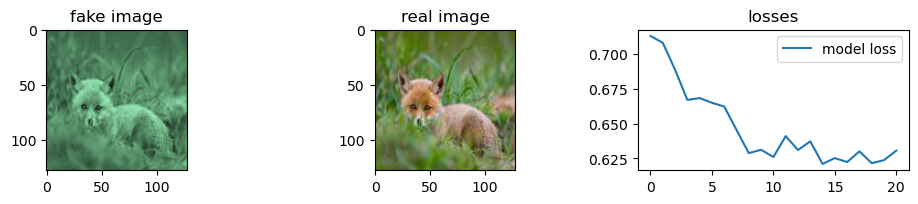

Epoch 21/1000: <==========> ------- model loss = 0.6201848387718201, time = 20.0s
Epoch 22/1000: <==========> ------- model loss = 0.6401655673980713, time = 20.0s
Epoch 23/1000: <==========

KeyboardInterrupt: 

In [14]:
%matplotlib inline
losses = train_model3(model, train_loader, epochs = 1000, device = DEVICE)